In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("./TakeHomeProject")
COLUMNS_PATH = DATA_DIR / "census-bureau.columns"
DATA_PATH = DATA_DIR / "census-bureau.data"

# Load column names
cols = [line.strip() for line in COLUMNS_PATH.read_text(encoding="utf-8").splitlines() if line.strip()]
assert len(cols) == 42, f"Expected 42 columns (40 vars + weight + label), got {len(cols)}"

# Load data
df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=cols,
    na_values=["?"],
    skipinitialspace=True,   # trims spaces after commas
    low_memory=False
)

# Clean up string columns (strip whitespace)
obj_cols = df.select_dtypes(include="object").columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.str.strip())

In [2]:
# Sanity checks
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

label_counts = df["label"].value_counts(dropna=False)
label_pct = (label_counts / len(df) * 100).round(2)
print("Label distribution:")
print(pd.DataFrame({"count": label_counts, "pct": label_pct}).to_string())

weight_summary = df["weight"].describe().to_frame(name="weight")
print("\nWeight summary:")
print(weight_summary.round(2).to_string())

# Weighted label distribution using the 'weight' column
weighted_counts = df.groupby("label")["weight"].sum()
weighted_pct = (weighted_counts / weighted_counts.sum() * 100).round(2)

print("\nWeighted label distribution:")
print(pd.DataFrame({
    "weighted_count": weighted_counts,
    "weighted_pct": weighted_pct
}).to_string())

Shape: (199523, 42)

Columns: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'vete

In [3]:
def preview_columns(df, n_samples=5):
    for col in df.columns:
        s = df[col]
        non_null = s.dropna()
        print(f"\n=== {col} ===")
        print(f"dtype: {s.dtype}")
        print(f"rows: {len(s):,} | non-null: {non_null.size:,} | missing: {s.isna().mean():.2%}")
        print(f"unique (non-null): {non_null.nunique():,}")
        sample_vals = non_null.sample(min(n_samples, len(non_null)), random_state=0).tolist()
        print(f"sample values: {sample_vals}")

preview_columns(df, n_samples=5)


=== age ===
dtype: int64
rows: 199,523 | non-null: 199,523 | missing: 0.00%
unique (non-null): 91
sample values: [40, 54, 46, 35, 50]

=== class of worker ===
dtype: object
rows: 199,523 | non-null: 199,523 | missing: 0.00%
unique (non-null): 9
sample values: ['Private', 'State government', 'Private', 'Private', 'Federal government']

=== detailed industry recode ===
dtype: int64
rows: 199,523 | non-null: 199,523 | missing: 0.00%
unique (non-null): 52
sample values: [4, 43, 32, 42, 29]

=== detailed occupation recode ===
dtype: int64
rows: 199,523 | non-null: 199,523 | missing: 0.00%
unique (non-null): 47
sample values: [40, 9, 16, 8, 31]

=== education ===
dtype: object
rows: 199,523 | non-null: 199,523 | missing: 0.00%
unique (non-null): 17
sample values: ['Some college but no degree', 'Doctorate degree(PhD EdD)', 'Bachelors degree(BA AB BS)', 'Bachelors degree(BA AB BS)', 'Bachelors degree(BA AB BS)']

=== wage per hour ===
dtype: int64
rows: 199,523 | non-null: 199,523 | missing: 

In [4]:
# Basic data health
print("\nDuplicates:", df.duplicated().sum())

missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing fraction (top 15):\n", missing.head(15))

nunique = df.nunique(dropna=True).sort_values(ascending=False)
print("\nUnique values per column (top 15):\n", nunique.head(15))

mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nEstimated memory usage: {mem_mb:,.1f} MB")

# Near-constant columns (top category share >= 95%)
near_constant = []
for col in df.columns:
    vc = df[col].value_counts(dropna=True)
    if vc.empty:
        continue
    top_share = vc.iloc[0] / len(df)
    if top_share >= 0.95:
        near_constant.append((col, vc.index[0], top_share, len(vc)))

if near_constant:
    print("\nNear-constant columns (top >=95%):")
    for col, top_val, share, ncat in sorted(near_constant, key=lambda x: -x[2]):
        print(f"{col}: top='{top_val}' share={share:.4f} categories={ncat}")
else:
    print("\nNear-constant columns: none (top category <95%)")


Duplicates: 3229

Missing fraction (top 15):
 migration prev res in sunbelt     0.499672
migration code-change in msa      0.499672
migration code-change in reg      0.499672
migration code-move within reg    0.499672
country of birth father           0.033645
country of birth mother           0.030668
country of birth self             0.017006
hispanic origin                   0.004380
state of previous residence       0.003548
age                               0.000000
major occupation code             0.000000
major industry code               0.000000
marital stat                      0.000000
enroll in edu inst last wk        0.000000
wage per hour                     0.000000
dtype: float64

Unique values per column (top 15):
 weight                                99800
dividends from stocks                  1478
wage per hour                          1240
capital gains                           132
capital losses                          113
age                                 

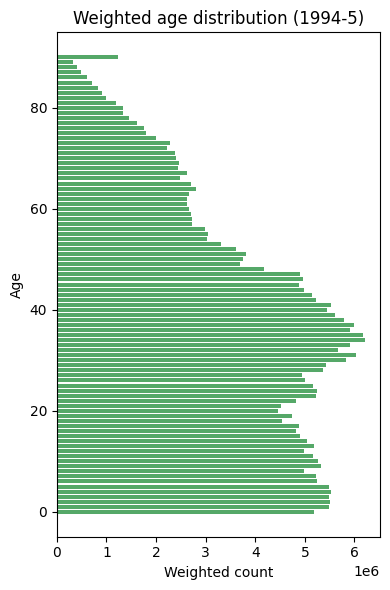

In [6]:
# age distribution
ages = df["age"]   
weights = df.loc[ages.index, "weight"]
age_weights = ages.groupby(ages).apply(lambda s: weights.loc[s.index].sum()).sort_index()

plt.figure(figsize=(4, 6))
plt.barh(age_weights.index, age_weights.values, color="#55A868")
plt.xlabel("Weighted count")
plt.ylabel("Age")
plt.title("Weighted age distribution (1994-5)")
plt.tight_layout()
